# Introduction

NMF is a technique that enables parts-based learning. Matrix factorization allows image reduction and decomposition into its elementary parts. Unlike techniques such as PCA, the non-negativity constraint on matrices—consistent with the non-negative pixel values of images—allows NMF to produce interpretable image reconstructions based on additive components (the whole is the sum of its parts).


In [ ]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
faces = fetch_olivetti_faces()
X = faces.data # dataset di 400 immagini con risoluzione 64x64
X.shape
X = MinMaxScaler().fit_transform(X) #matrice 4096 x 400

components_range = range(1,21)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


The goal is to apply NMF to an image dataset, using different update rules and initializing the problem with various approaches. A comparison of the different methods follows.


**Multiplicative Update**

In [ ]:
#Multiplicative Update (MU). Original NMF algorithm of Lee & Seung(1999)
#Multiplicative updates that never increase the error (guarantees monotonic convergence). X is approximately W @ H. Easy to implement, but it has slow convergence and is sensitive to initialization."

errors_nmf = []
for num_comp in components_range:
  model_MU = NMF(n_components= num_comp, solver = 'mu',beta_loss='kullback-leibler', init='nndsvda', max_iter=500) #Initialize with non-negative SVD with averaging (initialize with k non-negative components from SVD; set negative values to zero; average components that are poorly represented)
  W = model_MU.fit_transform(X)
  H = model_MU.components_
  X_approx = np.dot(W, H)
  reconstruction_error_nmf = np.linalg.norm(X - X_approx)
  errors_nmf.append(reconstruction_error_nmf)

print("Reconstruction error:", reconstruction_error_nmf)
print(W.shape) # matrix 400 x 20
print(H.shape) # 20 x 4096

Reconstruction error: 135.12881
(400, 20)
(20, 4096)


Below, we visualize the basis images (components) extracted using NMF. These can be interpreted as parts of the original images that the algorithm uses to reconstruct the input.


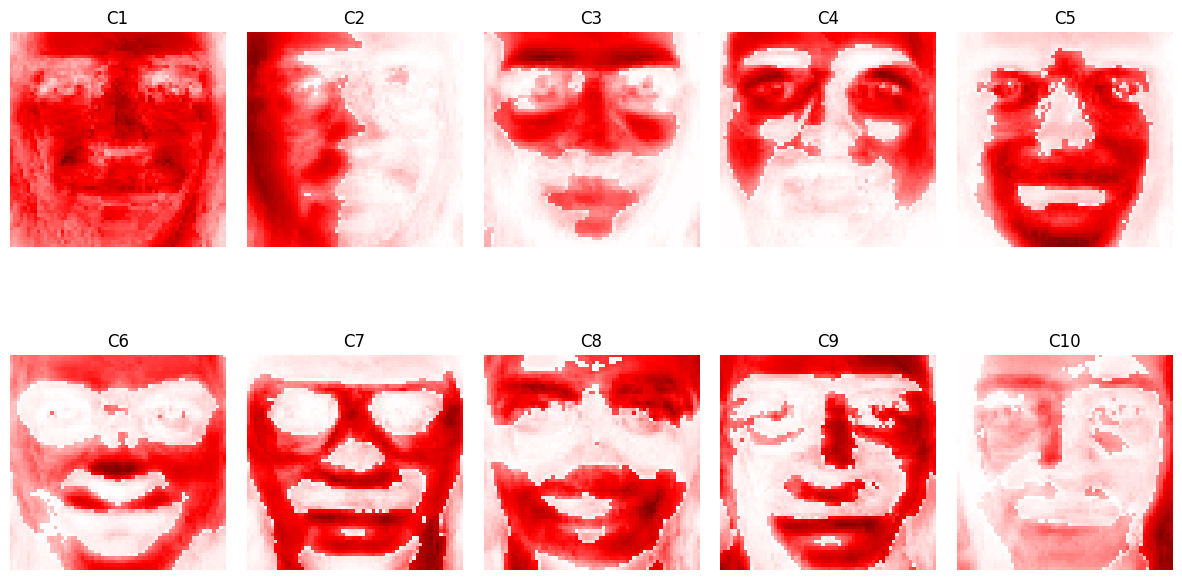

In [ ]:
#Visualization of components the problem has defined in H
fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(H[i].reshape(64, 64), cmap='seismic', vmin=-np.max(np.abs(H[i].reshape(64, 64))), vmax = np.max(np.abs(H[i].reshape(64, 64)))),
    ax.set_title(f'C{i+1}')
    ax.axis('off')



In [ ]:
print(H[:5])

[[1.191e-02 1.689e-02 5.913e-03 ... 6.745e-02 4.908e-02 3.208e-02]
 [1.300e+00 1.379e+00 1.367e+00 ... 1.727e-04 3.957e-03 5.022e-02]
 [3.314e-01 3.024e-01 2.688e-01 ... 1.872e-01 2.157e-01 3.269e-01]
 [4.309e-02 1.568e-01 4.091e-01 ... 1.607e-07 1.858e-07 1.439e-05]
 [4.849e-03 1.490e-02 1.005e-02 ... 1.417e-04 1.665e-05 9.446e-05]]


It is also possible to observe how the reconstructed image is approximately represented compared to the original one, using 20 components.


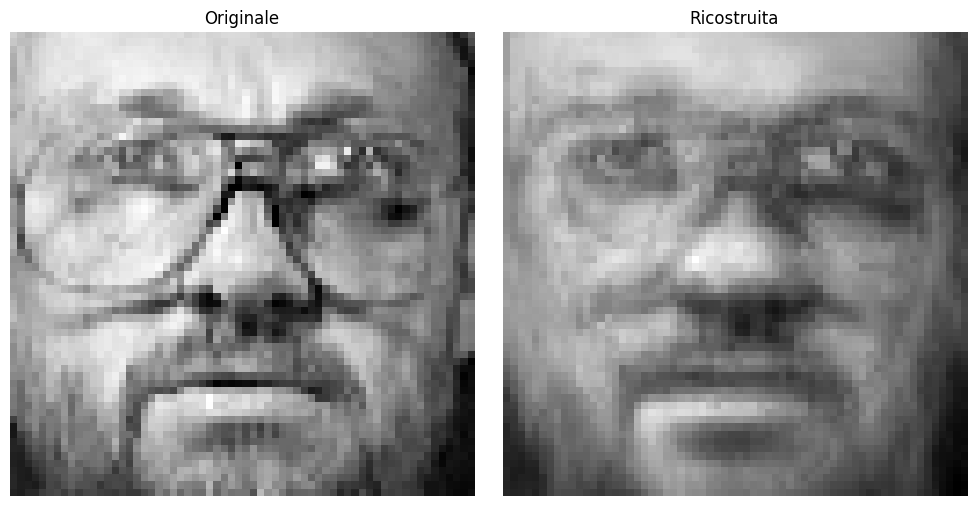

In [ ]:
index = 0
images = data.images
targets = data.target
original_img = X[index].reshape(64, 64)
reconstructed_img = X_approx[index].reshape(64, 64)


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_img, cmap='gray')
axes[0].set_title("Originale")
axes[0].axis('off')

axes[1].imshow(reconstructed_img, cmap='gray')
axes[1].set_title("Ricostruita")
axes[1].axis('off')

plt.tight_layout()
plt.show()

**Coordinate Descent Algorithm**

This algorithm solves the problem of minimizing the Frobenius norm by alternately optimizing
𝑊
W and
𝐻
H, one column of
𝑊
W or one row of
𝐻
H at a time. It implicitly uses L2 regularization. It tends to converge faster than other methods but requires careful tuning of the regularization parameter. The approach is very similar to Alternating Least Squares (ALS).

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 50 reached. Increase it to improve convergence.
  warnings.warn(


Reconstruction error: 152.77823


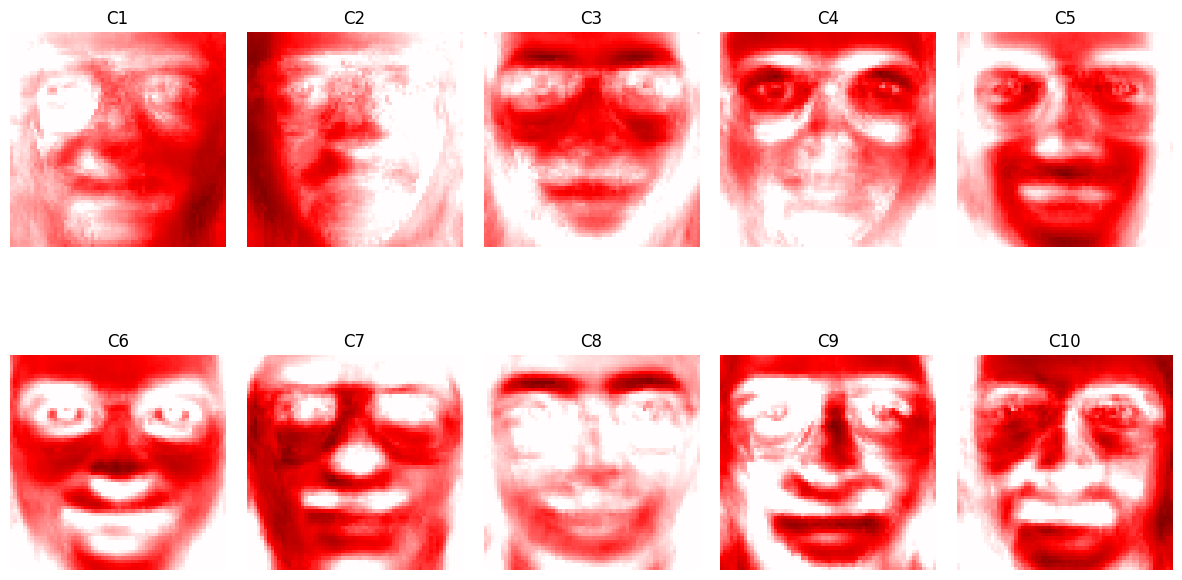

In [ ]:
X = MinMaxScaler().fit_transform(X)

model_CD = NMF(n_components=10, solver = 'cd', init='nndsvda', max_iter=50) #inizilizza con non-negative svd con average(inizilizza con k componenti della svd non negative; pone a zero le negative; fa una media per componenti poco rappresentate)
W_CD = model_CD.fit_transform(X)
H_CD= model_CD.components_
X_approx_CD = np.dot(W_CD, H_CD)

reconstruction_error_CD = np.linalg.norm(X - X_approx_CD)



fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(H_CD[i].reshape(64, 64), cmap='seismic', vmin=-np.max(np.abs(H_CD[i].reshape(64, 64))), vmax = np.max(np.abs(H_CD[i].reshape(64, 64))))
    ax.set_title(f'C{i+1}')
    ax.axis('off')

print("Reconstruction error:", reconstruction_error_CD)

In [ ]:
print(H_CD[:10]) #it is clear how the sparsity is present on the matrix's pixel; a lot of components are 0 in some images

[[0.    0.    0.    ... 1.792 0.734 1.185]
 [3.303 3.405 3.143 ... 0.411 0.598 0.855]
 [0.    0.    0.    ... 4.748 5.122 5.798]
 ...
 [0.386 0.415 0.344 ... 0.    0.    0.013]
 [0.198 0.323 0.416 ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.881 0.864 0.889]]


**Comparison by using PCA with 20 PCs**

Let’s now apply PCA for comparison. PCA does not impose non-negativity constraints and uses orthogonal linear combinations.


In [ ]:
from sklearn.decomposition import PCA

122.03129


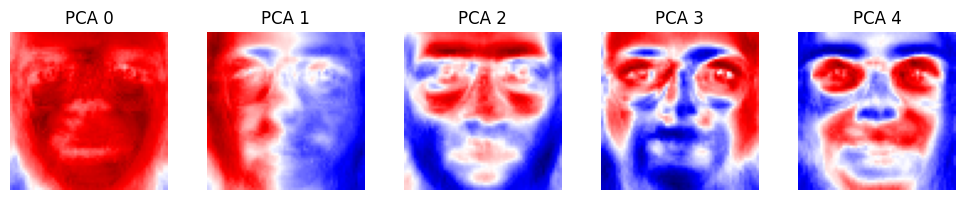

In [ ]:
errors_pca =[]

for num_comp in components_range:
  pca = PCA(n_components = num_comp, random_state = 0)
  Z = pca.fit_transform(X)  # 400 x 20 matrix
  W_pca = pca.components_   #20 x 4096 matrix
  X_approx_pca = pca.inverse_transform(Z)    # Reconstruction
  error_pca = np.linalg.norm(X - X_approx_pca)
  errors_pca.append(error_pca)



print(error_pca)

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(W_pca[i].reshape(64, 64), cmap='seismic', vmin=-np.max(np.abs(W_pca[i].reshape(64, 64))), vmax=np.max(np.abs(W_pca[i].reshape(64, 64))))
    ax.set_title(f"PCA {i}")
    ax.axis('off')
plt.tight_layout()
plt.show()

It is possibile to observe the negativity of components and the non sparsity of the matrix. This is a clear difference from NMF technique.

It is clearly observed that NMF finds localized parts, such as eyes or nose, whereas PCA captures global patterns like shadows or tonal variations. In NMF, fewer components are active for each image, which helps interpret each image as a sum of a few parts.

In [ ]:
print(W_pca[:5])

[[ 0.005  0.007  0.009 ... -0.002 -0.004 -0.004]
 [ 0.028  0.031  0.034 ... -0.025 -0.024 -0.023]
 [ 0.001 -0.001 -0.001 ... -0.01  -0.009 -0.008]
 [-0.003 -0.001  0.009 ... -0.018 -0.018 -0.017]
 [-0.025 -0.026 -0.024 ... -0.023 -0.022 -0.025]]


Comparison of component activations of the first 10 images obtained from two dimensionality reduction methods: NMF and PCA.

On the left plot, it shows the activation matrix W from NMF, highlighting how each of the first 10 images is represented by a sparse combination of components.

On the right plot, it displays the coefficient matrix Z from PCA, illustrating how each image is described by global components with denser activations.

Colorbars indicate the magnitude of activations or coefficients, providing insight into the sparsity and nature of the learned features for each method.

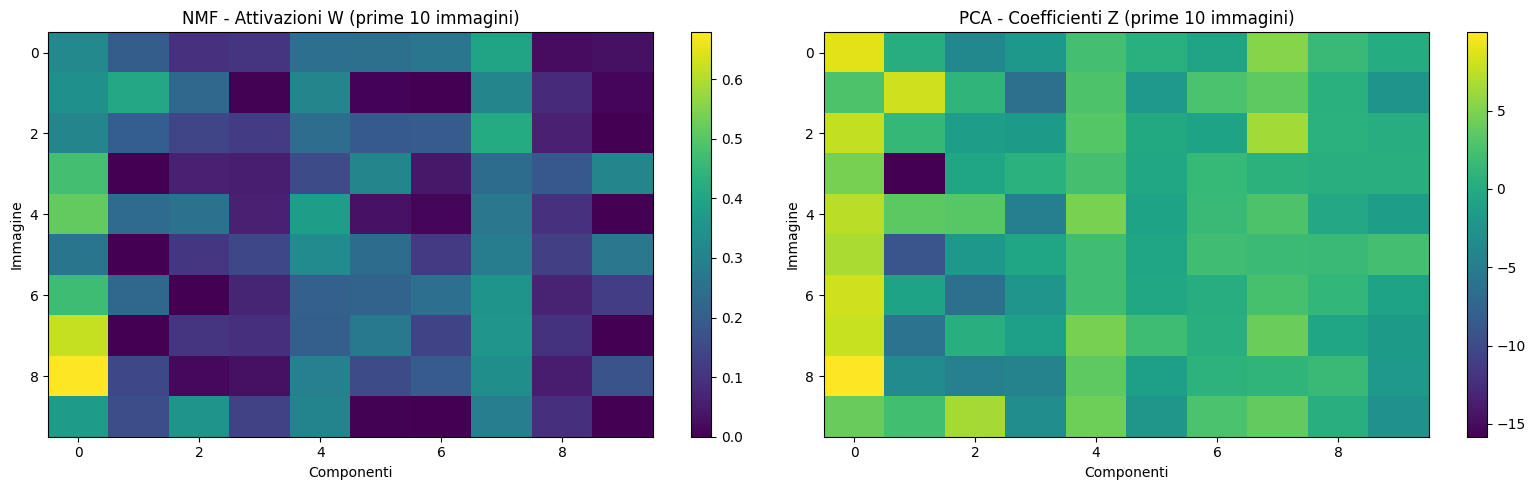

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

#NMF
im1 = axes[0].imshow(W[:10], aspect='auto', cmap='viridis')
axes[0].set_title("NMF - Attivazioni W (prime 10 immagini)")
axes[0].set_xlabel("Componenti")
axes[0].set_ylabel("Immagine")
fig.colorbar(im1, ax=axes[0])

#PCA
im2 = axes[1].imshow(Z[:10], aspect='auto', cmap='viridis')
axes[1].set_title("PCA - Coefficienti Z (prime 10 immagini)")
axes[1].set_xlabel("Componenti")
axes[1].set_ylabel("Immagine")
fig.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

**Vector Quantization**

What if we consider using vector quantization (VQ)?

Each image is approximated by a limited number of prototypes called codebook vectors. The goal is to find a codebook consisting of k vectors (centroids) that minimize the average distance to the data points. Typically, k-means is used for this purpose. Unlike NMF, there is no constraint of non-negativity or that the centroids sum to one.

In [ ]:
from sklearn.cluster import KMeans

180.96524


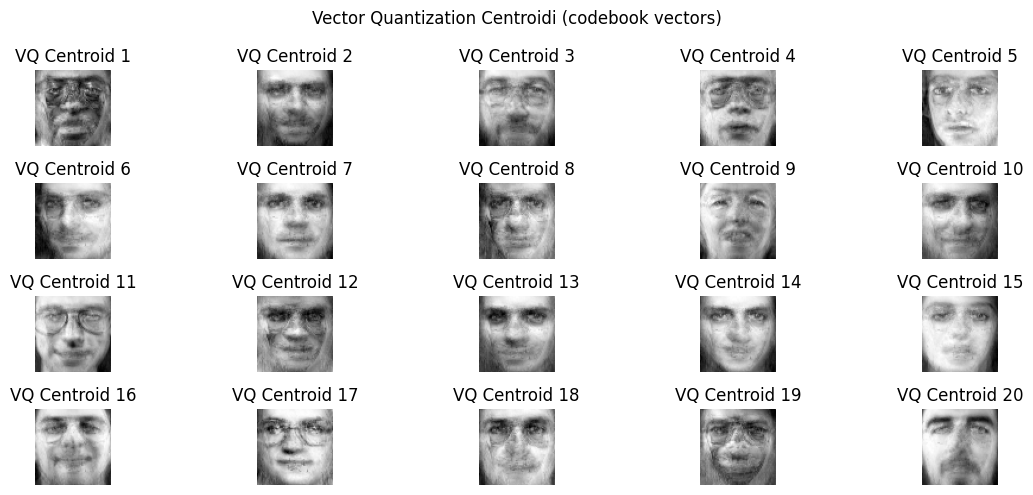

In [ ]:
errors_vq = []
for num_comp in components_range:
  kmeans = KMeans(n_clusters=num_comp, random_state=0)
  labels = kmeans.fit_predict(X)
  centroids = kmeans.cluster_centers_  # shape (10, 4096)

  X_vq_approx = centroids[labels] #images reconstruction
  error_vq = np.linalg.norm(X - X_vq_approx)
  errors_vq.append(error_vq)

print(error_vq) #higher of NMF, lower than PCA


#Visualization of VQ centroids as images
fig, axes = plt.subplots(4, 5, figsize=(12,5))
axes = axes.flatten()
for i, centroid in enumerate(centroids):
    axes[i].imshow(centroid.reshape(64, 64), cmap='gray')
    axes[i].set_title(f"VQ Centroid {i+1}")
    axes[i].axis('off')
plt.suptitle("Vector Quantization Centroidi (codebook vectors)")
plt.tight_layout()
plt.show()

The previous figure shows the centroids (codebook vectors) obtained. Each centroid represents a prototype face that captures common features shared by multiple images in the dataset. These centroids serve as representative building blocks to approximate original images by assigning each to its closest prototype. The visualizations highlight how VQ captures typical facial patterns, although the centroids may appear somewhat blurred due to averaging over multiple samples.

Matrix of centroids, associated to the first 5 images of Olivetti dataset.

In [ ]:
print(centroids[:5])

[[0.255 0.269 0.263 ... 0.341 0.37  0.402]
 [0.438 0.491 0.519 ... 0.202 0.221 0.294]
 [0.485 0.557 0.57  ... 0.239 0.246 0.292]
 [0.666 0.715 0.701 ... 0.255 0.273 0.336]
 [0.303 0.339 0.308 ... 0.627 0.676 0.746]]


It is observed that as the number of components used to represent the original images increases, the reconstruction error tends to decrease. The overall error is quite high, it may be useful to use more components. PCA and NMF errors follow a closer path than the one of Vector Quantization, which is slightly higher in value.

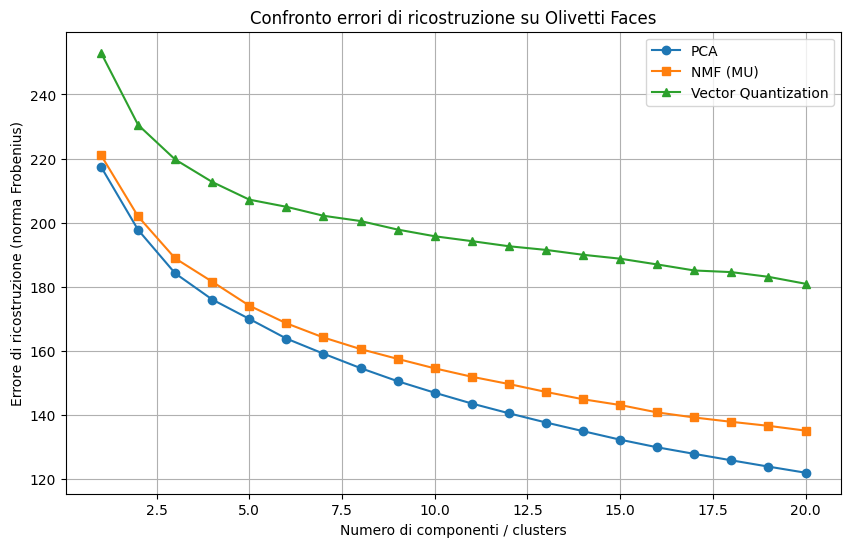

In [ ]:
#Comparison of error reconstruction changing the number of components
plt.figure(figsize=(10,6))
plt.plot(components_range, errors_pca, label='PCA', marker='o')
plt.plot(components_range, errors_nmf, label='NMF (MU)', marker='s')
plt.plot(components_range, errors_vq, label='Vector Quantization', marker='^')
plt.xlabel('Numero di componenti / clusters')
plt.ylabel('Errore di ricostruzione (norma Frobenius)')
plt.title('Confronto errori di ricostruzione su Olivetti Faces')
plt.legend()
plt.grid(True)
plt.show()


**CNN Autoencoder**

An autoencoder is a type of unsupervised neural network designed to reconstruct its own input. It consists of two parts:

Encoder:
It compresses the input into a smaller representation (a "code" or feature vector).
For example, it can reduce an image of size 64×64 pixels into a small feature map of 8×8.

Decoder:
Starting from the code, it tries to reconstruct the original input as accurately as possible.

A CNN (Convolutional Neural Network) works with images by extracting patterns and reducing the image’s dimensions to obtain a compact encoding (similar to the component vector H in NMF). Then the image is upsampled to reconstruct the original image, which can be compared to the input.

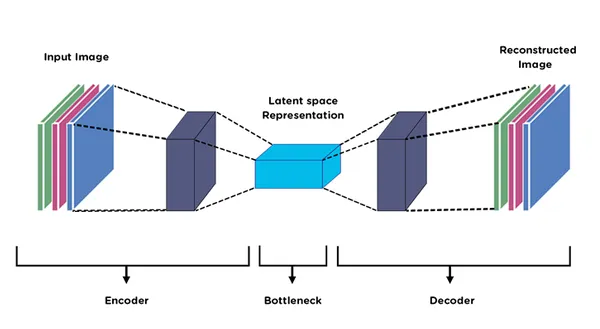

Creating the CNN autoencoder.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split


In [ ]:
X = X.reshape(-1, 64, 64, 1) # -1 automatically calculates the number of samples
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
X_train.shape

(320, 64, 64, 1)

In [ ]:
input_img = layers.Input(shape=(64, 64, 1))

#Encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 32x32x32
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 16x16x16
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # 8x8x8 #bottleneck

#Decoder
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)  # 16x16x8
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)  # 32x32x16
# Added padding='same' to the next Conv2D layer
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)  # 64x64x32
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

#Model
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
 autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test)
)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - loss: 0.6891 - val_loss: 0.6767
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - loss: 0.6778 - val_loss: 0.6693
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - loss: 0.6713 - val_loss: 0.6559
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - loss: 0.6561 - val_loss: 0.6367
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - loss: 0.6395 - val_loss: 0.6199
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - loss: 0.6256 - val_loss: 0.6147
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - loss: 0.6239 - val_loss: 0.6122
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - loss: 0.6222 - val_loss: 0.6098
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - loss: 0.6196 - val_loss: 0.6076
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - loss: 0.6182 - val_loss: 0.6059
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.6159 - val_loss: 0.6045
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step

Comparison between the reconstructed images and the original images shows a low resolution in the reconstructed output. This is due to the bottleneck compressing the image from 64×64 pixels (4096 pixels) down to only 512 values. Information loss is therefore inevitable.

The use of max-pooling progressively reduces the spatial resolution. Although the deconvolutions reconstruct the image, since the model is not very deep, they do not produce sharp details.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


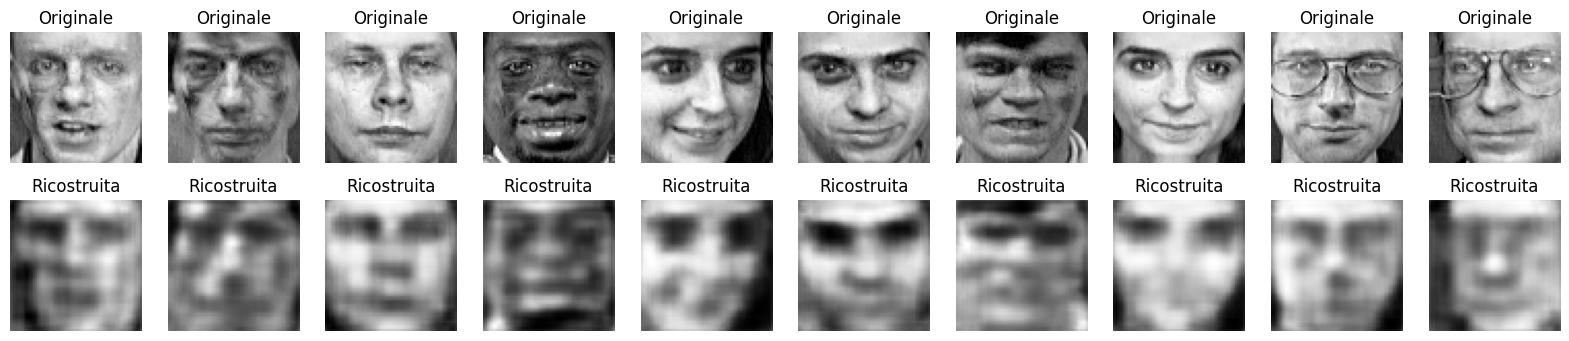

In [ ]:
decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    #Immagini originali
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(64, 64), cmap='gray')
    plt.title("Originale")
    plt.axis("off")

    #Immagini ricostruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(64, 64), cmap='gray')
    plt.title("Ricostruita")
    plt.axis("off")
plt.show()


The features extracted at the bottleneck represent activations that indicate the presence or absence of certain characteristics in the image. To improve the model, one can try increasing the bottleneck size or using more filters in the convolutional layers. Additionally, implementing skip connections can help.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


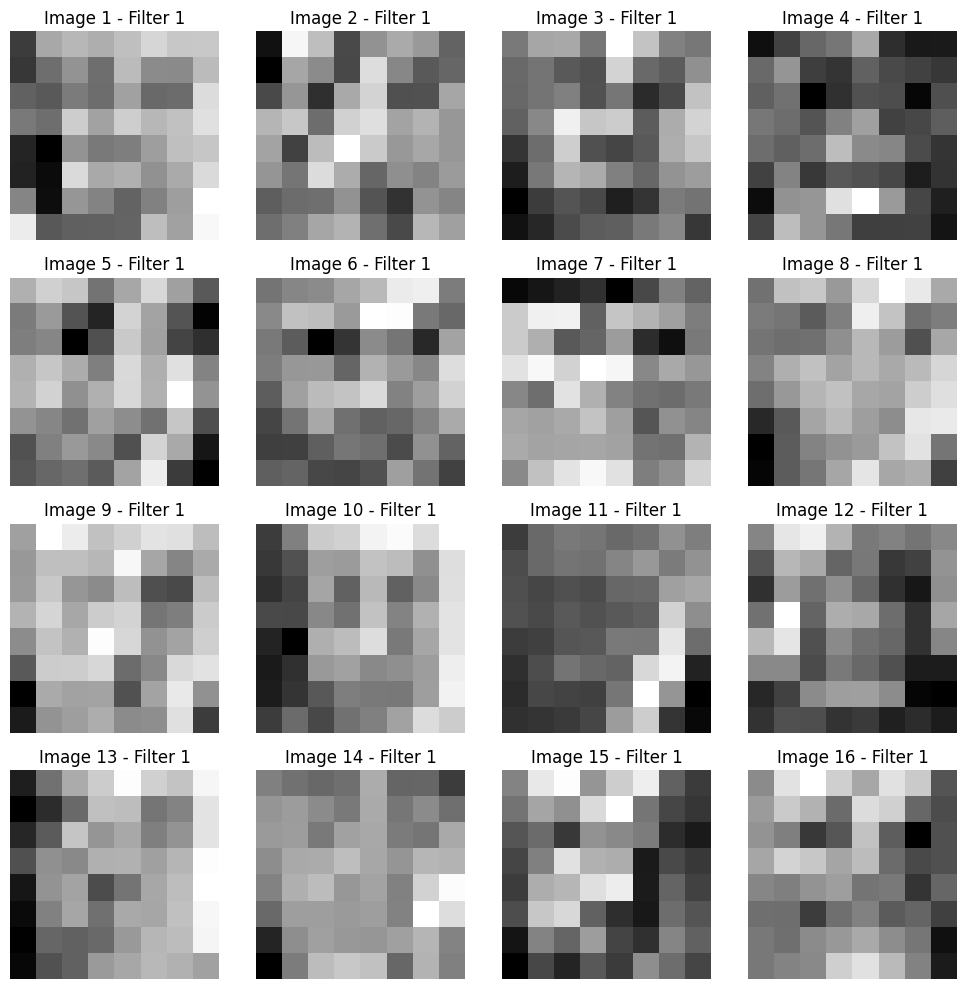

In [ ]:
#Feature extraction from the bottleneck
encoder = models.Model(inputs=autoencoder.input, outputs=encoded)
features = encoder.predict(X_test)  # shape: (n, 8, 8, 8) number of images ,H,W, number of filters

plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(features[i][:, :, 0], cmap='gray')
    plt.title(f"Image {i+1} - Filter 1")
    plt.axis("off")
plt.tight_layout()
plt.show()

Using the stochastic t-SNE algorithm, I want to visualize in a 2D space the encodings learned by NMF and by the CNN autoencoder, in order to visually compare how well they separate different individuals’ faces.

With NMF, t-SNE forms fairly distinct clusters, while for the CNN autoencoder the points are much more scattered. This suggests that the CNN autoencoder produces more generalized or less separable features for each person.

This behavior may certainly depend on the model’s capacity and the size of the bottleneck.

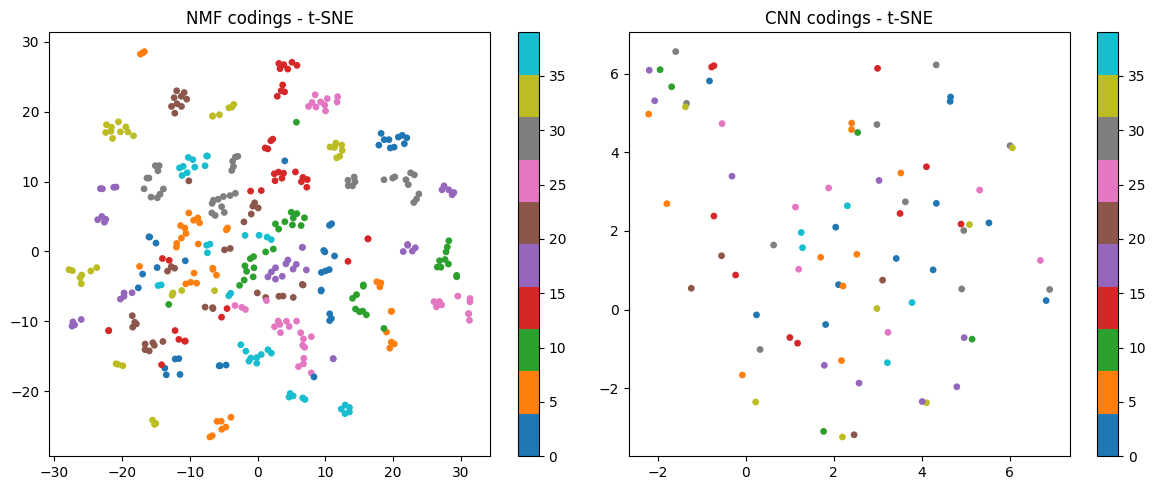

In [ ]:
from sklearn.manifold import TSNE

#Flatten features CNN (from the bottleneck)
features_flat = features.reshape(len(features), -1)

#t-SNE over CNN encodings
tsne_cnn = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results_cnn = tsne_cnn.fit_transform(features_flat)

#t-SNE over NMF encodings
tsne_nmf = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results_nmf = tsne_nmf.fit_transform(W)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(tsne_results_nmf[:, 0], tsne_results_nmf[:, 1], c=y, cmap='tab10', s=15)
plt.title("NMF codings - t-SNE")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(tsne_results_cnn[:, 0], tsne_results_cnn[:, 1], c=y_test, cmap='tab10', s=15)
plt.title("CNN codings - t-SNE")
plt.colorbar()

plt.tight_layout()
plt.show()


**PCA Projection – Interpretation**

The PCA projections highlight clear differences between the NMF and CNN codings:

- *NMF codings (left plot)* appear more compact and slightly clustered, suggesting some class structure is preserved even in a linear 2D projection. However, the overlap is still quite high, meaning NMF doesn't fully separate the classes in this space.
  
- *CNN codings (right plot)* are much more scattered and sparse, with little visible clustering. This might suggest that the CNN encodings, after flattening, lose meaningful structure or are not optimized for class separation in a linear space like PCA.

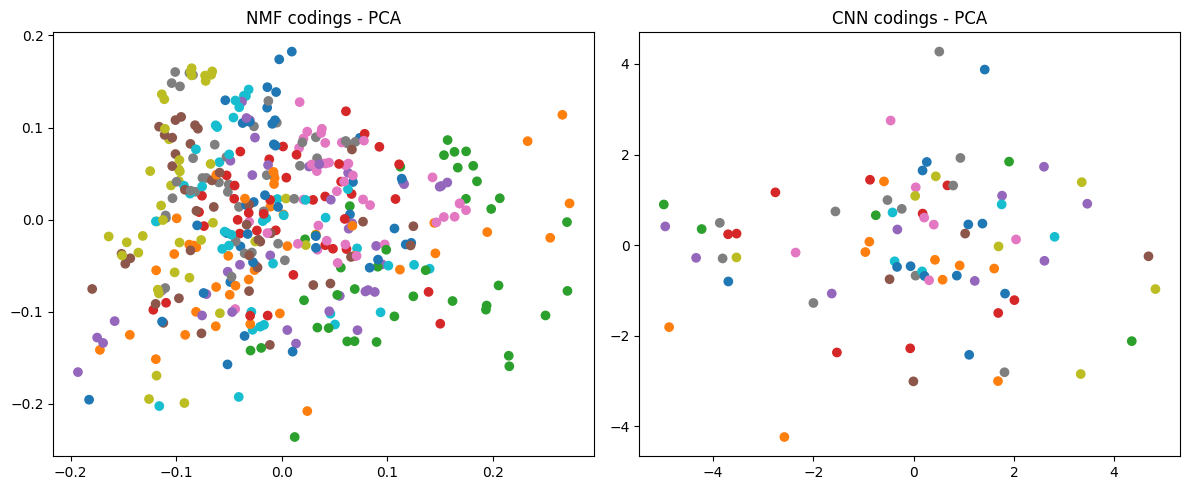

In [ ]:
y_test = data.target[:len(features)]
y = data.target

#Autoencoder encodings
features_flat = features.reshape(len(features), -1)
pca_cnn = PCA(n_components=2).fit_transform(features_flat)

#NMF encodings
pca_nmf = PCA(n_components=2).fit_transform(W)


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(pca_nmf[:, 0], pca_nmf[:, 1], c= y, cmap='tab10')
plt.title("NMF codings - PCA")

plt.subplot(1, 2, 2)
plt.scatter(pca_cnn[:, 0], pca_cnn[:, 1], c= y_test, cmap='tab10')
plt.title("CNN codings - PCA")

plt.tight_layout()
plt.show()


NMF shows slightly better class organization in PCA than CNN.
- The flattening step in CNN likely discards spatial coherence useful for class separation.
- Nonlinear projections like t-SNE or UMAP might give better insights for CNN features.

### Conclusion

In this mini report, we investigated different techniques for learning compact representations of face images, including PCA, Non-negative Matrix Factorization (NMF), and a Convolutional Neural Network (CNN) autoencoder. The comparison showed how NMF provides more interpretable and distinct feature bases compared to PCA, which tends to produce global components. Applying t-SNE to the codings learned by NMF and the CNN autoencoder highlighted differences in feature separability: NMF codings clustered into well-defined groups corresponding to individuals, whereas the CNN autoencoder’s features appeared more dispersed, possibly reflecting a more generalized representation.

This study represents an initial approach to image reconstruction and feature extraction. By enhancing model architectures, increasing bottleneck dimensions, and using more complex datasets, it is possible to improve the quality of the learned representations. Such improved encodings could serve as efficient inputs for downstream tasks like image segmentation or classification on real-world data.

Overall, this project lays a solid foundation for further research in image processing, dimensionality reduction, and deep feature learning.

